# Reinforcement Learning - Toy examples with Gym

## FrozenLake

In this Notebook, we will implement $SARSA$ and $Q-Learning$ methods to solve the FrozenLake-v0 environment (https://gym.openai.com/envs/FrozenLake-v0/), using and comparing different policies for exploration.

Both algorithms update a tabular estimate of the $Q-function$ using a following update rule:
* $SARSA$ algorithm is an on-policy method using:
$$Q_{t+1}(s_t,a_t) \leftarrow Q_t(s_t,a_t) + \alpha (r_t + \gamma Q_t(s_{t+1}, a_{t+1}) - Q_t(s_t,a_t))$$

* $Q-Learning$ algorithm is an off-policy method using:
$$Q_{t+1}(s_t,a_t) \leftarrow Q_t(s_t,a_t) + \alpha (r_t + \gamma \max_b Q_t(s_{t+1}, b) - Q_t(s_t,a_t))$$

For exploration, we will compare performances between:
* $\epsilon$-greedy policy with a fixed $\epsilon$.
* $\epsilon$-greedy policy with a decaying $\epsilon$.
* softmax exploration assigning a probability for an action to be
performed according to the following rule:
$$P(a_i \vert s) = \frac{e^{\frac{1}{\tau}Q(s,a_j)}}{\sum_j e^{\frac{1}{\tau}Q(s,a_j)}}$$

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [3]:
env = gym.make('FrozenLake-v0')

c:\environments\drl_env\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Function: chooseAction

Returns an action (integer belonging to the action space of the FrozenLake-v0's environment) given:
* a $Q$-table
* a state
* $\epsilon$
* $softmax$: boolean set to $True$ if softmax exploration is used
* $\tau$: parameter of the softmax exploration.

In [4]:
def chooseAction(q_table, state, epsilon = 0, softmax = True, tau = 0.01):
    if softmax:
        m = max(q_table[state])
        aux = np.exp((q_table[state] - m)/tau)
        d = np.sum(aux)
        return np.random.choice (np.arange(env.action_space.n), p=aux / d)
    if np.random.random () > epsilon:
        return np.argmax(q_table[state])
    return env.action_space.sample()

### Function: routine

Body function used to implement both $SARSA$ and $Q$-Learning, since only the estimation of the error changes between the two methods.

* $algo$: either "SARSA" or "QLearning"
* $nEpisode$: number of episodes we simulate to update our $Q$-function
* $\gamma \in [0,1]$: discount factor
* $\alpha \in (0,1]$: learning rate
* $\epsilon_0$: initial value of $\epsilon$
* $\epsilon_{min}$: minimal value of $\epsilon$ if a decaying $\epsilon$ is used
* $decreaseRate \in (0,1]$: geometric parameter of the decaying of $\epsilon$ (set to 1 if no decaying)
* $softmax$: boolean set to $True$ if softmax exploration is used
* $\tau$: parameter of the softmax exploration
* $window$: number of episodes we consider to compute the success rate (or accuracy) of the $Q$-function ; ratio of successes on the last $window$ episodes

In [36]:
def routine(algo, nEpisode = 20000, gamma = 0.99, alpha = 0.4, epsilon0 = 0.9, epsilonMin = 0.05, decreaseRate = 0.999, softmax = False, tau = 0.01, window = 100):
    accuracy = 0
    epsilon = epsilon0
    q_table = np.ones((env.observation_space.n, env.action_space.n))
    result = np.zeros (window)
    histAcc = [0]
    episode = 0
    
    for ep in range(nEpisode):
        epsilon = max(epsilonMin, decreaseRate * epsilon)
        observation0 = env.reset()
        action0 = chooseAction(q_table, observation0, epsilon, softmax, tau)
        done  = False
        for H in range(200):
            observation1, reward, done, info = env.step(action0)
            action1 = chooseAction(q_table, observation1, epsilon, softmax, tau)
            err = reward - q_table[observation0, action0]
            
            if not done:
                if algo == "SARSA":
                    err += gamma * q_table[observation1, action1]
                if algo == "QLearning":
                    err += gamma * q_table[observation1, np.argmax(q_table[observation1])]
            
            q_table[observation0, action0] += alpha * err
            
            if done:
                break
            
            observation0, action0 = observation1, action1

        success = 1 if (reward == 1) else 0
        accuracy += (success - result[episode]) / window
        result[episode] = success
        episode = (episode + 1) % window
        if episode == 0 or episode == window//2: # accuracy ratio is stored once in @window/2 episodes
            histAcc.append(accuracy)

    return q_table, histAcc

### SARSA

Text(0.5, 1.0, 'SARSA training on 5000 episodes')

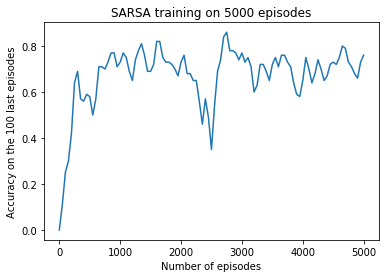

In [37]:
def SARSA(nEpisode = 2000, gamma = 0.999, alpha = 0.4, epsilon0 = 0.9, epsilonMin = 0.05, decreaseRate = False, softmax = True, tau = 0.01, window = 100):
    return routine("SARSA", nEpisode, gamma, alpha, epsilon0, epsilonMin, decreaseRate, softmax, tau, window)


w = 100
nEpisode = 5000
q_table, histAcc = SARSA(nEpisode, softmax = True, window=w, tau = 0.001)
plt.plot(w // 2 * np.arange(len(histAcc)), histAcc)

plt.xlabel("Number of episodes")
plt.ylabel("Accuracy on the {} last episodes".format(w))
plt.title("SARSA training on {} episodes".format(nEpisode))

In [35]:
q_table

array([[1.08581754e-04, 6.47443188e-02, 1.35781370e-03, 2.07070495e-03],
       [0.00000000e+00, 2.07538623e-02, 0.00000000e+00, 0.00000000e+00],
       [4.95097904e-02, 3.10335719e-03, 1.96199207e-04, 2.58026360e-04],
       [1.96708401e-03, 8.23232493e-04, 2.32073923e-04, 2.13131428e-03],
       [2.23031504e-01, 9.08158595e-04, 1.30702743e-03, 5.71152075e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.52487200e-02, 5.36837351e-04, 3.18845601e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.72611703e-05, 1.51816467e-04, 1.82000671e-04, 2.38205720e-01],
       [5.34807783e-05, 4.74440883e-04, 1.05814567e-01, 2.30065429e-04],
       [1.49137036e-01, 2.13410865e-04, 7.40413156e-04, 2.60375047e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.80151224e-03, 1.41126295e-03, 6.12022964e

### $Q$-Learning

Text(0.5, 1.0, 'Q-Learning training on 2000 episodes')

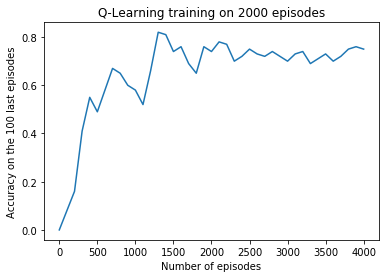

In [14]:
def QLearning(nEpisode = 5000, gamma = 0.999, alpha = 0.4, epsilon0 = 0.9, epsilonMin = 0.05, decreaseRate = True, softmax = False, tau = 0.003, window = 100):
    return routine("QLearning", nEpisode, gamma, alpha, epsilon0, epsilonMin, decreaseRate, softmax, tau, window)

w = 100
nEpisode = 2000
q_table, histAcc = QLearning (nEpisode, softmax = True, window=w)
plt.plot(100 * np.arange(len(histAcc)), histAcc)

plt.xlabel("Number of episodes")
plt.ylabel("Accuracy on the {} last episodes".format(w))
plt.title("Q-Learning training on {} episodes".format(nEpisode))

In [15]:
def testPolicy (q_table, nEpisode = 2000):
    success = 0
    for _ in range(nEpisode):
        t = 0
        observation = env.reset()
        done  = False
        actionTable = np.argmax(q_table, axis = 1)
        while not done and t < 200:
            action = actionTable[observation]
            observation, reward, done, info = env.step(action)
            t += 1

        if reward == 1:
            success += 1
    return success / nEpisode

## Compare methods

In [16]:
recap = pd.DataFrame (columns = ["Accuracy - SARSA", "Accuracy - QLearning"])

N = 10000

### $\epsilon$-greedy with fixed $\epsilon$

In [ ]:
n = 5
Eps = 0.1 * np.arange(1, 10)

for eps in Eps:
    sarsa = 0
    ql = 0
    for _ in range(n):
        q_table, histAcc = QLearning (N, epsilon0 = eps, decreaseRate=1)
        ql += testPolicy(q_table)
        q_table, histAcc = SARSA (N, epsilon0 = eps, decreaseRate=1)
        sarsa += testPolicy(q_table)
    sarsa /= n
    ql /= n
    recap.loc["Fixed $\epsilon$ : $\epsilon$ = {}".format(round(eps,2))] = [sarsa, ql]

0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8


In [ ]:
recap

### $\epsilon$-greedy with decaying $\epsilon$

In [ ]:
n = 5
dr = 0.99

for eps in [0.9, 0.5, 0.1]:
    sarsa = 0
    ql = 0
    for _ in range(n):
        q_table, histAcc = QLearning (N, epsilon0 = eps, decreaseRate=dr)
        ql += testPolicy(q_table)
        q_table, histAcc = SARSA (N, epsilon0 = eps, decreaseRate=dr)
        sarsa += testPolicy(q_table)
    sarsa /= n
    ql /= n
    recap.loc["Decaying $\epsilon$ : $\epsilon_0$ = {}".format(eps)] = [sarsa, ql]


In [ ]:
recap

### Softmax

In [ ]:
n = 5

for t in [1, 0.1, 0.01, 0.001]:
    sarsa = 0
    ql = 0
    for _ in range(n):
        q_table, histAcc = QLearning(N, softmax = True, tau = t)
        ql += testPolicy(q_table)
        q_table, histAcc = SARSA(N, softmax = True, tau = t)
        sarsa += testPolicy(q_table)
    sarsa /= n
    ql /= n
    recap.loc["Softmax : $\tau$ = {}".format(t)] = [sarsa, ql]

recap